<a href="https://colab.research.google.com/github/eceirem/Hukuki-Asistan/blob/main/with_llm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!sudo apt-get install poppler-utils
!pip install pdf2image json_repair requests

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  poppler-utils
0 upgraded, 1 newly installed, 0 to remove and 41 not upgraded.
Need to get 186 kB of archives.
After this operation, 697 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 poppler-utils amd64 22.02.0-2ubuntu0.12 [186 kB]
Fetched 186 kB in 0s (737 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package poppler-utils.
(Reading database ... 121713

In [ ]:
import pytesseract # Artık kullanılmayacak, sadece tanımlı kalıyor
from pdf2image import convert_from_path
import json
import re
import os
import random
import requests
from google.colab import drive
from typing import Dict, Any, List
import base64
from io import BytesIO
from PIL import Image

# --- SABİT AYARLAR ---
pytesseract.pytesseract.tesseract_cmd = 'tesseract'
POPPLER_PATH = None

# ⚠️ GEREKLİ: OpenRouter API Anahtarınız
OPENROUTER_API_KEY = "**"

# --- LLM AYARLARI ---
# Vision destekli modelin adı (':free' etiketi kaldırıldı, ücretli krediler kullanılıyor)
LLM_MODEL_NAME = "amazon/nova-2-lite-v1"
LLM_BASE_URL = "https://openrouter.ai/api/v1/chat/completions"


# --- SINIF TANIMI (PDF -> BASE64 İÇİN) ---

class LegalDocProcessor:
    def __init__(self):
        os.environ['TESSDATA_PREFIX'] = '/usr/share/tesseract-ocr/4.00/tessdata/'

    def pdf_to_base64_images(self, pdf_path: str) -> List[str]:
        """
        PDF sayfalarını Base64 kodlu JPEG görüntülerine çevirir.
        """
        base64_images = []
        try:
            # Görüntüleri al
            images = convert_from_path(pdf_path, dpi=300, poppler_path=POPPLER_PATH)

            # 🚨 UYARI: Birçok LLM Vision API'si, özellikle ücretsiz katmanlarda,
            # tek bir istekte gönderebileceğiniz görüntü sayısını sınırlar (örn: 10-20 sayfa).
            # 300 sayfalık belgeler varsa, buraya bir sınırlama eklenmelidir.
            # Şimdilik, tüm sayfaları göndermeye çalışıyoruz.

            for img in images:
                buffered = BytesIO()
                img.save(buffered, format="JPEG", quality=85)
                img_str = base64.b64encode(buffered.getvalue()).decode("utf-8")
                base64_images.append(img_str)

            return base64_images
        except Exception as e:
            print(f"PDF -> Base64 Hatası: {e}")
            return []


# --- YARDIMCI FONKSİYON: LLM İLE İŞLEME (VISION DESTEKLİ) ---

def process_with_openrouter_vision(base64_images: List[str], file_name: str, model_name: str, api_key: str) -> Dict[str, Any]:
    """
    OpenRouter API'sini kullanarak Base64 görüntülerden JSON yapısı çıkarır.
    """
    if not api_key:
        raise ValueError("API Anahtarı bulunamadı.")

    # summary_for_human ve summary_for_model alanları eklendi
    json_schema = {
        "meta_data": {
            "file_name": file_name,
            "court_name": "Mahkemenin tam adı",
            "esas_no": "Esas numarası",
            "karar_no": "Karar numarası",
            "case_subject": "Davanın konusunu belirten kısa bir cümle",
            "dava_tarihi": "Davanın açılış tarihi (DD/MM/YYYY)",
            "karar_tarihi": "Kararın verildiği tarih (DD/MM/YYYY)"
        },
        "rrl_segments": {
            "facts_text": "Davacının ve davalının iddia ve savunmalarının özetlendiği tüm kısım.",
            "reasoning_text": "Mahkemenin hukuki değerlendirmesini içeren kısım.",
            "verdict_text": "Hüküm fıkrasının tamamı."
        },
        "structural_features": {
            "mentioned_laws": ["Metin içinde geçen tüm kanun maddeleri ve kısaltmaları"]
        },
        "summary_for_human": "Davayı bir hakim gibi özetleyen, ancak bir insanın rahatça anlayacağı açıklayıcı dille yazılmış özet.",
        "summary_for_model": "Davanın temel hukuki dayanaklarını, tarafların iddialarını ve mahkemenin nihai karar gerekçesini içeren, teknik terimlerin korunduğu kısa, yoğun özet."
    }

    # Sistem promptu
    system_prompt = (
        "Sen, bir Türk Hukuku uzmanısın. Sana bir mahkeme kararının sayfalarının görselleri verilecektir. "
        "Görüntüleri analiz ederek metni oku ve istenen JSON formatında yapılandırılmış veriyi çıkar. "
        "1. **summary_for_human** alanına: Davayı mahkemenin bakış açısıyla (hakim gibi) özetleyen, ancak hukuki jargon kullanmadan, anlaşılır ve açıklayıcı bir dille bir özet ekle. "
        "2. **summary_for_model** alanına: Model eğitimi için kullanılabilecek, davanın **hukuki dayanaklarını** ve **nihai karar gerekçesini** içeren, **teknik terimleri koruyan** yoğun ve kısa bir özet ekle. "
        "Yalnızca JSON yapısını döndür. Hiçbir açıklama ekleme.\n\n"
        f"İstenen JSON yapısı şöyledir:\n{json.dumps(json_schema, ensure_ascii=False, indent=2)}"
    )

    user_messages = [{"type": "text", "text": f"Lütfen {file_name} adlı mahkeme kararının görsellerini incele ve istenen bilgileri çıkar."}]

    # Görüntüleri mesaja ekledik
    for img_b64 in base64_images:
        user_messages.append({
            "type": "image_url",
            "image_url": {
                "url": f"data:image/jpeg;base64,{img_b64}"
            }
        })

    headers = {
        "Authorization": f"Bearer {api_key}",
        "Content-Type": "application/json"
    }

    data = {
        "model": model_name,
        "messages": [
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_messages},
        ],
        "temperature": 0.1,
        "response_format": {"type": "json_object"}
    }

    print(f"LLM'e istek gönderiliyor ({model_name})...")

    try:
        response = requests.post(LLM_BASE_URL, headers=headers, json=data, timeout=600) # 10 dakika zaman aşımı
        response.raise_for_status()

        response_data = response.json()
        llm_response_content = response_data['choices'][0]['message']['content'].strip()

        # JSON temizliği
        llm_response_content = llm_response_content.replace("```json", "").replace("```", "").strip()

        return json.loads(llm_response_content)

    except requests.exceptions.HTTPError as e:
        print(f"HTTP Hatası: {e.response.status_code}")
        print(f"API Yanıtı: {e.response.text[:200]}...") # Hata metninin bir kısmını göster
        return None
    except Exception as e:
        print(f"İstek veya JSON ayrıştırma hatası: {e}")
        return None


# --- ANA ÇALIŞTIRMA BLOĞU (MAIN) ---

def main():
    drive.mount('/content/drive', force_remount=True)

    # KLASÖR YOLLARI
    base_dir = "/content/drive/MyDrive"
    input_folder = "Legal NLP/Dataset/WhatsApp"

    # Çıktı klasör adı
    output_folder = "Legal NLP/Codes/myoutputs/AllWpJsonswithSumm"

    input_dir = os.path.join(base_dir, input_folder)
    output_dir = os.path.join(base_dir, output_folder)

    if not os.path.exists(output_dir):
        os.makedirs(output_dir, exist_ok=True)
        print(f"Oluşturulan çıktı klasörü: {output_dir}")

    if not OPENROUTER_API_KEY:
        print("\n❌ HATA: Lütfen OPENROUTER_API_KEY değişkenini kontrol edin.")
        return

    if os.path.exists(input_dir):
        # SADECE PDF dosyalarını al
        all_files = [f for f in os.listdir(input_dir) if f.lower().endswith('.pdf')]

        if not all_files:
            print("Klasörde hiç PDF dosyası bulunamadı.")
            return

        print(f"Toplam {len(all_files)} adet dosya işlenecektir. Bu işlem zaman alabilir ve ücrete tabi olabilir.")

        processor = LegalDocProcessor()

        # Tüm dosyalar üzerinde DÖNGÜ BAŞLAT
        for i, selected_file in enumerate(all_files):
            selected_file_path = os.path.join(input_dir, selected_file)

            print(f"\n--- İŞLENİYOR: {i+1}/{len(all_files)} -> {selected_file} ---")

            # JSON dosyasının zaten var olup olmadığını kontrol et
            out_name = f"vision_llm_processed_{os.path.splitext(selected_file)[0]}.json"
            out_path = os.path.join(output_dir, out_name)

            # Eğer daha önce işlediyseniz ve sadece yeni alanları eklemek için tekrar çalıştırmak istiyorsanız
            # aşağıdaki 'continue' satırını yorum satırı yapmayı unutmayın!
            if os.path.exists(out_path):
                print("✅ Dosya daha önce işlenmiş, atlanıyor.")
                continue

            # 1. PDF'i Base64 Görüntülere Çevirme
            base64_images = processor.pdf_to_base64_images(selected_file_path)

            if not base64_images:
                 print("⚠️ PDF'ten görüntü çıkarılamadı. Dosya atlanıyor.")
                 continue

            # 2. LLM Vision API ile JSON Çıkarımı
            json_result = process_with_openrouter_vision(
                base64_images=base64_images,
                file_name=selected_file,
                model_name=LLM_MODEL_NAME,
                api_key=OPENROUTER_API_KEY
            )

            # 3. Sonucu Kaydet
            if json_result:
                try:
                    with open(out_path, 'w', encoding='utf-8') as f:
                        json.dump(json_result, f, ensure_ascii=False, indent=4)

                    print(f"🎉 BAŞARILI! JSON dosyası kaydedildi.")
                except Exception as e:
                    print(f"❌ JSON KAYIT HATASI: {e}")
            else:
                print("❌ LLM'den geçerli JSON çıktısı alınamadı. Dosya atlanıyor.")

        print("\n=== TOPLU İŞLEME TAMAMLANDI ===")

if __name__ == "__main__":
    main()

Mounted at /content/drive
Toplam 302 adet dosya işlenecektir. Bu işlem zaman alabilir ve ücrete tabi olabilir.

--- İŞLENİYOR: 1/302 -> 2020_327.pdf ---
✅ Dosya daha önce işlenmiş, atlanıyor.

--- İŞLENİYOR: 2/302 -> 2024_311.pdf ---
✅ Dosya daha önce işlenmiş, atlanıyor.

--- İŞLENİYOR: 3/302 -> 2021_1827.pdf ---
✅ Dosya daha önce işlenmiş, atlanıyor.

--- İŞLENİYOR: 4/302 -> 2022_1930.pdf ---
✅ Dosya daha önce işlenmiş, atlanıyor.

--- İŞLENİYOR: 5/302 -> 2024_1576.pdf ---
✅ Dosya daha önce işlenmiş, atlanıyor.

--- İŞLENİYOR: 6/302 -> 2023_1819.pdf ---
✅ Dosya daha önce işlenmiş, atlanıyor.

--- İŞLENİYOR: 7/302 -> 2023_626.pdf ---
✅ Dosya daha önce işlenmiş, atlanıyor.

--- İŞLENİYOR: 8/302 -> 2021_325.pdf ---
✅ Dosya daha önce işlenmiş, atlanıyor.

--- İŞLENİYOR: 9/302 -> 2024_145.pdf ---
✅ Dosya daha önce işlenmiş, atlanıyor.

--- İŞLENİYOR: 10/302 -> 2020_569.pdf ---
✅ Dosya daha önce işlenmiş, atlanıyor.

--- İŞLENİYOR: 11/302 -> 2020_497.pdf ---
✅ Dosya daha önce işlenmiş, atl

NotADirectoryError: [Errno 20] Not a directory: '/content/drive/MyDrive/Legal NLP/Codes/myoutputs/AllWpJsonswithSumm/vision_llm_processed_2022_293.json'

Aynı kod sadece ufak revizeler var:

max_tokens: 2000: Bu, 65.000 tokenlik felaketi %100 engeller. Dosya çok uzun olsa bile model 2000 tokende durur.

Prompt Güncellemesi: "Maksimum 150 kelime" gibi ifadelerle modelin gevezelik yapmasını engelledik.

Raporlama: Kodun sonunda output klasörüne bakıp kaç dosya olduğunu sayıp ekrana yazacak.

kod temizliği: gereksiz kütüphaneler kaldırıldı ve tüm kodu anlayın diye yorum satırları da eklendi


json_repair kullanıyoruz sebebi altta

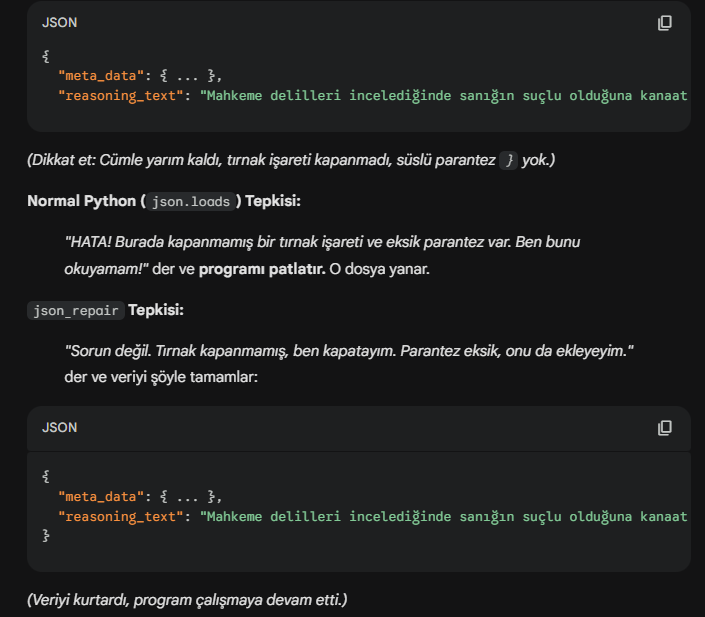

In [ ]:
import json
import os
import requests
import base64
from io import BytesIO
from typing import Dict, Any, List

# GEREKLİ KÜTÜPHANELER
from pdf2image import convert_from_path  # PDF'i resme çevirmek için
from google.colab import drive          # Google Drive bağlantısı için
from json_repair import repair_json      # LLM yarım bırakırsa JSON'ı tamir etmek için

# --- SABİT AYARLAR ---
POPPLER_PATH = None

# ⚠️ GEREKLİ: OpenRouter API Anahtarınız
OPENROUTER_API_KEY = "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"

# --- LLM AYARLARI ---
LLM_MODEL_NAME = "amazon/nova-2-lite-v1"
LLM_BASE_URL = "https://openrouter.ai/api/v1/chat/completions"

# --- SINIF TANIMI (PDF -> BASE64 İÇİN) ---
class LegalDocProcessor:
    def pdf_to_base64_images(self, pdf_path: str) -> List[str]:
        """PDF'in sayfalarını resme çevirir ve Base64 formatına kodlar."""
        base64_images = []
        try:
            images = convert_from_path(pdf_path, dpi=300, poppler_path=POPPLER_PATH)

            for img in images:
                buffered = BytesIO()
                img.save(buffered, format="JPEG", quality=85)
                img_str = base64.b64encode(buffered.getvalue()).decode("utf-8")
                base64_images.append(img_str)

            return base64_images
        except Exception as e:
            # print(f"PDF -> Base64 Dönüştürme Hatası: {e}")
            return []

# --- YARDIMCI FONKSİYON: LLM İLE İŞLEME ---
def process_with_openrouter_vision(base64_images: List[str], file_name: str, model_name: str, api_key: str) -> Dict[str, Any]:
    if not api_key:
        raise ValueError("API Anahtarı bulunamadı.")

    # Modelden istediğimiz çıktı şablonu (JSON Schema)
    json_schema = {
        "meta_data": {
            "file_name": file_name,
            "court_name": "Mahkemenin tam adı",
            "esas_no": "Esas numarası",
            "karar_no": "Karar numarası",
            "case_subject": "Davanın konusunu belirten kısa bir cümle",
            "dava_tarihi": "Davanın açılış tarihi (DD/MM/YYYY)",
            "karar_tarihi": "Kararın verildiği tarih (DD/MM/YYYY)"
        },
        "rrl_segments": {
            "facts_text": "ÖZET: İddia ve savunmalar (Max 200 kelime).",
            "reasoning_text": "ÖZET: Hukuki gerekçe (Max 200 kelime).",
            "verdict_text": "Hüküm sonucu (özetle)."
        },
        "structural_features": {
            "mentioned_laws": ["Metin içinde geçen tüm kanun maddeleri ve kısaltmaları"]
        },
        "summary_for_human": "İnsan için basit özet (Max 100 kelime).",
        "summary_for_model": "Model eğitimi için teknik özet (Max 100 kelime)."
    }

    # Modele verdiğimiz kesin talimatlar (System Prompt)
    system_prompt = ("Sen uzman bir hukuk asistanısısın. Görevin görseldeki mahkeme kararını analiz edip JSON verisi çıkarmaktır. "
        "KURALLAR:\n"
        "1. Asla metnin tamamını kopyalama. Metinleri kısıtlamalara uyarak **mutlaka özetle**.\n"
        "2. **facts_text** ve **reasoning_text** alanları için ÖZETLEME yap, MAX 200 kelimeyi geçme.\n"
        "3.  'structural_features' alanındaki **mentioned_laws** listesini ASLA ATLAMA ve tüm kanun maddelerini ekle.\n"
        "4. **Tekrarlama:** Asla tek bir cümleyi veya kelime grubunu tekrar etme. Cevabının döngüye girmesini önle.\n"
        "5. Sadece geçerli bir JSON döndür.\n\n"
        f"İstenen JSON şeması:\n{json.dumps(json_schema, ensure_ascii=False, indent=2)}"
    )

    user_messages = [{"type": "text", "text": f"Dosya adı: {file_name}. Lütfen kurallara uyarak analiz et."}]

    for img_b64 in base64_images:
        user_messages.append({
            "type": "image_url",
            "image_url": {"url": f"data:image/jpeg;base64,{img_b64}"}
        })

    headers = {"Authorization": f"Bearer {api_key}"}
    data = {
        "model": model_name,
        "messages": [
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_messages},
        ],
        "temperature": 0.1,
        "max_tokens": 4096, # Maliyet Sigortası
        "response_format": {"type": "json_object"}
    }

    print(f"LLM'e istek gönderiliyor ({model_name})...")

    try:
        response = requests.post(LLM_BASE_URL, headers=headers, json=data, timeout=600)
        response.raise_for_status()

        llm_response_content = response.json()['choices'][0]['message']['content'].strip().replace("```json", "").replace("```", "").strip()

        # 🛡️ JSON REPAIR: Yarım kalan veriyi kurtarır
        return repair_json(llm_response_content, return_objects=True)

    except Exception as e:
        print(f"❌ İstek veya JSON Tamir Hatası: {e}")
        return None

# --- ANA ÇALIŞTIRMA BLOĞU ---
def main():
    drive.mount('/content/drive', force_remount=True)

    base_dir = "/content/drive/MyDrive"

    # 📌 INPUT PATH (Tüm PDF'lerin toplandığı yer)
    input_folder = "Legal NLP/Dataset/All_PDFs_Consolidated"

    # 📌 OUTPUT PATH (Yapılandırılmış JSON'ların kaydedileceği yer)
    output_folder = "Legal NLP/Dataset/Structured_Judgements"

    input_dir = os.path.join(base_dir, input_folder)
    output_dir = os.path.join(base_dir, output_folder)

    if not os.path.exists(output_dir):
        os.makedirs(output_dir, exist_ok=True)

    if not os.path.exists(input_dir):
        print(f"❌ HATA: Giriş klasörü bulunamadı: {input_dir}")
        return

    all_files = [f for f in os.listdir(input_dir) if f.lower().endswith('.pdf')]
    all_files.sort()
    print(f"Toplam {len(all_files)} adet PDF dosyası bulundu. Sıralı işleme başlıyor...")

    processor = LegalDocProcessor()

    success_count = 0
    skipped_count = 0
    failed_files = []

    # 🏃 SIRALI İŞLEME DÖNGÜSÜ BAŞLIYOR
    for i, selected_file in enumerate(all_files):
        print(f"\n--- İŞLENİYOR: {i+1}/{len(all_files)} -> {selected_file} ---")

        out_name = f"vision_llm_processed_{os.path.splitext(selected_file)[0]}.json"
        out_path = os.path.join(output_dir, out_name)

        # ⏩ KONTROL: Dosya daha önce işlenmiş mi?
        if os.path.exists(out_path):
            print("✅ Dosya daha önce işlenmiş, atlanıyor.")
            skipped_count += 1
            continue

        # PDF -> Resim Dönüştürme
        base64_images = processor.pdf_to_base64_images(os.path.join(input_dir, selected_file))
        if not base64_images:
            print("❌ PDF'ten görüntü alınamadı (Boş veya bozuk PDF).")
            failed_files.append(selected_file)
            continue

        # LLM İşleme
        json_result = process_with_openrouter_vision(
            base64_images=base64_images,
            file_name=selected_file,
            model_name=LLM_MODEL_NAME,
            api_key=OPENROUTER_API_KEY
        )

        # Kaydetme
        if json_result:
            try:
                with open(out_path, 'w', encoding='utf-8') as f:
                    json.dump(json_result, f, ensure_ascii=False, indent=4)
                print(f"🎉 BAŞARILI! JSON kaydedildi.")
                success_count += 1
            except Exception as e:
                print(f"❌ JSON KAYIT HATASI: {e}")
                failed_files.append(selected_file)
        else:
            print("❌ LLM çıktısı alınamadı (Kritik Hata).")
            failed_files.append(selected_file)

    # --- FİNAL RAPORU ---
    print("\n\n=== SIRALI İŞLEME TAMAMLANDI ===")
    print(f"✅ Başarılı İşlenen (Yeni): {success_count}")
    print(f"⏩ Atlanan (Önceki işten kalan): {skipped_count}")
    print(f"❌ Hata Veren/Kayıt Edilemeyen: {len(failed_files)}")

    if len(failed_files) > 0:
        print("\nHata veren dosya isimlerinin listesi:")
        print(failed_files)

if __name__ == "__main__":
    main()

Mounted at /content/drive
Toplam 1001 adet PDF dosyası bulundu. Sıralı işleme başlıyor...

--- İŞLENİYOR: 1/1001 -> 2015_1106.pdf ---
✅ Dosya daha önce işlenmiş, atlanıyor.

--- İŞLENİYOR: 2/1001 -> 2015_94.pdf ---
✅ Dosya daha önce işlenmiş, atlanıyor.

--- İŞLENİYOR: 3/1001 -> 2015_982.pdf ---
✅ Dosya daha önce işlenmiş, atlanıyor.

--- İŞLENİYOR: 4/1001 -> 2016_1389.pdf ---
✅ Dosya daha önce işlenmiş, atlanıyor.

--- İŞLENİYOR: 5/1001 -> 2016_86.pdf ---
✅ Dosya daha önce işlenmiş, atlanıyor.

--- İŞLENİYOR: 6/1001 -> 2016_958.pdf ---
✅ Dosya daha önce işlenmiş, atlanıyor.

--- İŞLENİYOR: 7/1001 -> 2017_1107.pdf ---
✅ Dosya daha önce işlenmiş, atlanıyor.

--- İŞLENİYOR: 8/1001 -> 2017_1244.pdf ---
✅ Dosya daha önce işlenmiş, atlanıyor.

--- İŞLENİYOR: 9/1001 -> 2017_134.pdf ---
✅ Dosya daha önce işlenmiş, atlanıyor.

--- İŞLENİYOR: 10/1001 -> 2017_135.pdf ---
✅ Dosya daha önce işlenmiş, atlanıyor.

--- İŞLENİYOR: 11/1001 -> 2017_1359.pdf ---
✅ Dosya daha önce işlenmiş, atlanıyor.

--